In [163]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import loguniform

from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm 

from warnings import filterwarnings 
filterwarnings('ignore')

start_time = time.time()

#### 1. Datasets loading and transformations

In [166]:
# Load the data set
df = pd.read_csv('data/wdic.csv')
df_cpi = pd.read_csv('data/cpi.csv')
df_gdebt = pd.read_csv('data/gdebt.csv')
df_ratings = pd.read_csv('data/countriesratings.csv')
df_wind = pd.read_csv('data/worldeconomicindicators.csv')

In [167]:
# Checking data sample
#df.sample(3)
#combined_df.sample(3)
#combined_df.info()
#df.describe
#df_wind.info()

In [170]:
#df_cpi.sample(3)
#df_gdebt.sample(3)
#df_ratings.sample(3)
#df_wind.sample(3)

In [171]:
# Remove irelevant columns in df
df = df.drop(['Country Code', 'Indicator Code'], axis=1)

In [173]:
# Drop unwanted columns, merge and rename columns in df_wind
df_wind = df_wind.drop(['Scale', 'Estimates Start After', '2024', '2025', '2026', '2027', '2028', '2029', '2030'], axis=1)
df_wind['Indicator'] = df_wind['Subject Descriptor'].str.cat(df_wind['Units'], sep='-')
df_wind = df_wind.drop(['Subject Descriptor', 'Units'], axis=1)
#df_wind.sample(3)

In [175]:
#df_wind.sample(3)
#df_wind.info()

In [177]:
# Transform dataframe with Features as columns and year as one single column

# Step 1: Pivot the 'Indicator' column to create new columns for each indicator
# We use 'Country Name' as the index, 'Indicator Name' as columns, and the years as values.
# The 'columns' argument of pivot_table creates new columns from the unique values in 'Indicator'.
# The 'values' argument specifies which columns contain the values to be placed under the new indicator columns.

#====================== Process df ==================================#
years_df = [col for col in df.columns if str(col).isdigit()] # Dynamically get year columns
df_pivot = df.pivot_table(index='Country Name', columns='Indicator Name', values=years_df)
#df_pivot.sample(3)

#====================== Process df_cpi ==============================#
years_cpi = [col for col in df_cpi.columns if str(col).isdigit()] # Dynamically get year columns
df_cpi_pivot = df_cpi.pivot_table(index='COUNTRY', columns='INDEX_TYPE', values=years_cpi)
#df_cpi_pivot.sample(3)

#====================== Process df_gdebt ============================#
years_gdebt = [col for col in df_gdebt.columns if str(col).isdigit()] # Dynamically get year columns
df_gdebt_pivot = df_gdebt.pivot_table(index='COUNTRY', columns='INDICATOR', values=years_gdebt)
#df_gdebt_pivot.sample(3)

#====================== Process df_wind ============================#
# Ensure column names are strings for consistency
df_wind.columns = df_wind.columns.map(lambda x: str(int(x)) if isinstance(x, float) and x.is_integer() else x)

# Identify year columns
years_wind = [col for col in df_wind.columns if str(col).isdigit()]

# Melt to long format
df_wind_long = df_wind.melt(id_vars=['Country', 'Indicator'],
                            value_vars=years_wind,
                            var_name='Year',
                            value_name='Value')
df_wind_long_grouped = (
    df_wind_long
    .groupby(['Country', 'Year', 'Indicator'], as_index=False)
    .agg({'Value': 'first'})  # or 'mean', 'max', etc.
)

# Pivot (MultiIndex: Year, Indicator)
df_wind_pivot = df_wind_long_grouped.pivot(index='Country', columns=['Year', 'Indicator'], values='Value')
#df_wind_pivot.sample()

In [179]:
# Step 2: Flatten the MultiIndex columns
# This creates new column names like '2021_Population', '2021_GDP', etc.

#====================== Process df ==================================#
df_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_pivot.columns]
df_pivot = df_pivot.reset_index() # Reset index to make 'Country' a regular column
#df_pivot.sample(3)

#====================== Process df_cpi ==============================#
df_cpi_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_cpi_pivot.columns]
df_cpi_pivot = df_cpi_pivot.reset_index() # Reset index to make 'Country' a regular column
#df_cpi_pivot.sample(3)

#====================== Process df_gdebt ============================#
df_gdebt_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_gdebt_pivot.columns]
df_gdebt_pivot = df_gdebt_pivot.reset_index() # Reset index to make 'Country' a regular column
#df_gdebt_pivot.sample(3)

#====================== Process df_wind ============================#
df_wind_pivot.columns = [f"{year}_{indicator}" for year, indicator in df_wind_pivot.columns]
df_wind_pivot = df_wind_pivot.reset_index() # Reset index to make 'Country' a regular column
#df_wind_pivot.sample(3)

In [180]:
# Step 3: Melt the year-indicator columns into 'Year' and individual indicator columns
# We use 'Country Name' as id_vars (identifier variables).
# We want to create a 'Year' column and columns for 'Population', 'GDP', 'Inflation', etc..
# First, prepare for melting by creating a combined 'Year_Indicator' column
# Now, we want to melt the year-specific columns back into a single 'Year' column.
# The `id_vars` will be 'Country Name'.
# The `value_vars` will be all the new columns that combine year and indicator.

# Dynamically get the columns that combine year and indicator (e.g., '2021_Population')

#====================== Process df ==================================#
melt_value_vars = [col for col in df_pivot.columns if '_' in col] # Simple way to get them after flattening

df_final = pd.melt(df_pivot,
                   id_vars=['Country Name'],
                   value_vars=melt_value_vars,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Now, separate 'Year' and 'Indicator' from 'Year_Indicator'
df_final[['Year', 'Indicator']] = df_final['Year_Indicator'].str.split('_', expand=True)

# Finally, pivot again to get 'Population', 'GDP', 'Inflation' as columns
df_final = df_final.pivot_table(index=['Country Name', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # Use aggfunc='first' as there's only one value per combination

# Clean up column names (remove the 'Indicator' name from the columns)
df_final.columns.name = None
#df_final.head(3)

#====================== Process df_cpi ==============================#
melt_value_vars_df_cpi = [col for col in df_cpi_pivot.columns if '_' in col] # Simple way to get them after flattening

df_cpi_final = pd.melt(df_cpi_pivot,
                   id_vars=['COUNTRY'],
                   value_vars=melt_value_vars_df_cpi,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Now, separate 'Year' and 'Indicator' from 'Year_Indicator'
df_cpi_final[['Year', 'Indicator']] = df_cpi_final['Year_Indicator'].str.split('_', expand=True)

# Finally, pivot again to get 'Population', 'GDP', 'Inflation' as columns
df_cpi_final = df_cpi_final.pivot_table(index=['COUNTRY', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # Use aggfunc='first' as there's only one value per combination

# Clean up column names (remove the 'Indicator' name from the columns)
df_cpi_final.columns.name = None
#df_cpi_final.head(3)

#====================== Process df_gdebt ============================#
melt_value_vars_df_gdebt = [col for col in df_gdebt_pivot.columns if '_' in col] # Simple way to get them after flattening

df_gdebt_final = pd.melt(df_gdebt_pivot,
                   id_vars=['COUNTRY'],
                   value_vars=melt_value_vars_df_gdebt,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Now, separate 'Year' and 'Indicator' from 'Year_Indicator'
df_gdebt_final[['Year', 'Indicator']] = df_gdebt_final['Year_Indicator'].str.split('_', expand=True)

# Finally, pivot again to get 'Population', 'GDP', 'Inflation' as columns
df_gdebt_final = df_gdebt_final.pivot_table(index=['COUNTRY', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # Use aggfunc='first' as there's only one value per combination

# Clean up column names (remove the 'Indicator' name from the columns)
df_gdebt_final.columns.name = None
#df_gdebt_final.head(3)

#====================== Process df_wind ============================#
melt_value_vars_df_wind = [col for col in df_wind_pivot.columns if '_' in col] # Simple way to get them after flattening

df_wind_final = pd.melt(df_wind_pivot,
                   id_vars=['Country'],
                   value_vars=melt_value_vars_df_wind,
                   var_name='Year_Indicator', # This temporary column will hold '2021_Population' etc.
                   value_name='Value')

# Now, separate 'Year' and 'Indicator' from 'Year_Indicator'
df_wind_final[['Year', 'Indicator']] = df_wind_final['Year_Indicator'].str.split('_', expand=True)

# Finally, pivot again to get 'Population', 'GDP', 'Inflation' as columns
df_wind_final = df_wind_final.pivot_table(index=['Country', 'Year'],
                                columns='Indicator',
                                values='Value',
                                aggfunc='first').reset_index() # Use aggfunc='first' as there's only one value per combination

# Clean up column names (remove the 'Indicator' name from the columns)
df_wind_final.columns.name = None

In [182]:
#df_wind_final[df_wind_final['Country'] == 'India'][['Year','Population-Persons']].sort_values('Year')

In [183]:
#print(df_wind_final.columns.tolist())

In [185]:
# Process ratings data frame and prepare it for merge
# Select only the latest rating for each year by sorting date and selecting the latest row (closeest to month of december of the year)
df_ratings['Date'] = pd.to_datetime(df_ratings['Date'])
df_sorted = df_ratings.sort_values(by='Date')
df_latest = (
    df_sorted
    .groupby(['Country', 'Year'], as_index=False)
    .tail(1)
    .sort_values(by=['Country', 'Year', 'Date'])
    .reset_index(drop=True)
)
df_ratings_final = df_latest.copy()
#df_ratings_final.shape

In [186]:
# Check and process duplicates if necesary
print("="*50)
print(f"Total number of duplicates for df:", df_final.duplicated().sum())
print(f"Total number of duplicates for df_cpi:", df_cpi_final.duplicated().sum())
print(f"Total number of duplicates for df_gdebt:", df_gdebt_final.duplicated().sum())
print(f"Total number of duplicates for df_ratings:", df_ratings_final.duplicated().sum())
print(f"Total number of duplicates for df_wind:", df_wind_final.duplicated().sum())
print("="*50)

Total number of duplicates for df: 0
Total number of duplicates for df_cpi: 0
Total number of duplicates for df_gdebt: 0
Total number of duplicates for df_ratings: 0
Total number of duplicates for df_wind: 0


In [187]:
# Standardize column names to lower case and change data types where applicable in all data frames

# Change to lower case all column names for all dataframes
df_final.columns = [col.lower() for col in df_final.columns]
df_cpi_final.columns = [col.lower() for col in df_cpi_final.columns]
df_gdebt_final.columns = [col.lower() for col in df_gdebt_final.columns]
df_ratings_final.columns = [col.lower() for col in df_ratings_final.columns]
df_wind_final.columns = [col.lower() for col in df_wind_final.columns]

# Convert year columns in Datetime data type for all dataframes
df_final['year'] = pd.to_datetime(df_final['year'], errors='coerce').dt.year
df_cpi_final['year'] = pd.to_datetime(df_cpi_final['year'], errors='coerce').dt.year
df_gdebt_final['year'] = pd.to_datetime(df_gdebt_final['year'], errors='coerce').dt.year
df_wind_final['year'] = pd.to_datetime(df_wind_final['year'], errors='coerce').dt.year

# Rename df country name to country in preparation of merge joint
df_final.rename(columns={'country name': 'country'}, inplace=True)

# Convert data types in df
# Define the string patterns that, if present in the column name, should prevent conversion
# to Int64 (i.e., keep them as float64)
patterns_to_exclude = ['%', 'percent', 'standard error', 'estimate', 'period average', 'index'] # Patterns to exclude from conversion

# Identify columns to potentially convert
columns_to_check = []
for col in df_final.columns:
    # Check if the column is float64
    if df_final[col].dtype == 'float64':
        # Check if any of the exclusion patterns are NOT in the column name
        # We want to convert if the column name DOES NOT contain any of the exclusion patterns
        should_convert = True
        for pattern in patterns_to_exclude:
            if pattern in col.lower(): # Case-insensitive check
                should_convert = False
                break # Found an exclusion pattern, no need to check further
        if should_convert:
            columns_to_check.append(col)

print("="*150)
print(f"\nColumns identified for potential conversion to Int64: {columns_to_check}")

# Perform the conversion with rounding for problematic columns
for col in columns_to_check:
    # Check if the column contains any non-integer values (e.g., 1.5, 2.7)
    # Exclude NaNs from this check as Int64 handles them.
    # We check if after dropping NaNs, any value is not equal to its integer cast.
    has_fractional_parts = ((df_final[col].dropna() % 1) != 0).any()

    if has_fractional_parts:
        print(f"Warning: Column '{col}' contains fractional parts. Rounding before converting.")
        # Round to the nearest integer. .round() handles NaNs gracefully.
        df_final[col] = df_final[col].round().astype('Int64')
    else:
        # If no fractional parts, or only NaNs, direct cast should work.
        df_final[col] = df_final[col].astype('Int64')
    print(f"Converted '{col}' to Int64.")
    
print("="*150)
#print("\nFinal dtypes:")
#print(df_final.dtypes)
#df_final.sample(2)


Columns identified for potential conversion to Int64: ['central government debt, total (current lcu)', 'compulsory education, duration (years)', 'current account balance (bop, current us$)', 'current health expenditure per capita, ppp (current international $)', 'goods exports (bop, current us$)', 'goods imports (bop, current us$)']
Converted 'central government debt, total (current lcu)' to Int64.
Converted 'compulsory education, duration (years)' to Int64.
Converted 'current account balance (bop, current us$)' to Int64.
Converted 'current health expenditure per capita, ppp (current international $)' to Int64.
Converted 'goods exports (bop, current us$)' to Int64.
Converted 'goods imports (bop, current us$)' to Int64.


In [188]:
# Check values for outlook column for encoding
print("="*90)
print(df_ratings_final['outlook'].unique().tolist())
print("="*90)

['Stable', 'Negative', 'Positive', 'Positive Watch', 'Negative Watch', 'Under Review', nan]


In [189]:
# Encode and select outlook values to be used for each year

# Encode values for priority
outlook_priority = {
    'Negative': 1,
    'Negative Watch': 1,
    'Under Review': 2,
    'Stable': 3,
    'Positive Watch': 4,
    'Positive': 5,
    np.nan: 99  # Treat NaN as lowest priority or ignore
}

# Clean up strings
df_ratings_final['outlook'] = df_ratings_final['outlook'].str.strip()

# Add new column with ecoded priorities
df_ratings_final['outlookrank'] = df_ratings_final['outlook'].map(outlook_priority)


# Select the most conservative outlook for each year 
df_outlook = (
    df_ratings_final.groupby(['country', 'year'])
      .apply(lambda g: g.loc[g['outlookrank'].idxmin()])
      .reset_index(drop=True)
)

print("="*50)
print(f"Total number of duplicates for df_ratings_final:", df_ratings_final.duplicated().sum())
print("="*50)
#df_outlook

Total number of duplicates for df_ratings_final: 0


In [190]:
#df_ratings_final.sample(10)
#df_final.info()

#### 2. Datasets merged into a consolidated Data Frame ready for cleanup and imputation

In [195]:
#List of countries that do not exist isn df_final but exists in df_ratings_final
countries_not_in_df_final = df_ratings_final[~df_ratings_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*150)
print("Countries from df_ratings_final not in df_final:\n", countries_not_in_df_final)
print("="*150)

#List of countries that do not exist is df_final but exists in df_cpi_final
countries_not_in_df_final = df_cpi_final[~df_cpi_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*150)
print("Countries from df_cpi_final not in df_final:\n", countries_not_in_df_final)
print("="*150)

#List of countries that do not exist is df_final but exists in df_gdebt_final
countries_not_in_df_final = df_gdebt_final[~df_gdebt_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*150)
print("Countries from df_gdebt_final not in df_final:\n", countries_not_in_df_final)
print("="*150)

#List of countries that do not exist is df_final but exists in df_gdebt_final
countries_not_in_df_final = df_wind_final[~df_wind_final['country'].isin(df_final['country'])]['country'].unique().tolist()
print("="*150)
print("Countries from df_gdebt_final not in df_final:\n", countries_not_in_df_final)
print("="*150)

Countries from df_ratings_final not in df_final:
 ['Swaziland', 'Taiwan']
Countries from df_cpi_final not in df_final:
 ['Anguilla, United Kingdom-British Overseas Territory', "Côte d'Ivoire", 'Guadeloupe', 'Martinique', 'Montserrat, United Kingdom-British Overseas Territory']
Countries from df_gdebt_final not in df_final:
 ["Côte d'Ivoire", 'Taiwan Province of China']
Countries from df_gdebt_final not in df_final:
 ["Cote d'Ivoire", 'S\x81EEEo Tom\x81EEE and Pr\x81EEEncipe', 'Taiwan Province of China']


In [200]:
# Merge all Data Frames in one single Data Frame in two stages
merged_df_1 = pd.merge(df_final, df_cpi_final, on=['country', 'year'], how='left')
merged_df_2 = pd.merge(merged_df_1, df_gdebt_final, on=['country', 'year'], how='left')
merged_df_3 = pd.merge(merged_df_2, df_wind_final, on=['country', 'year'], how='left')
final_merged_df = pd.merge(merged_df_3, df_ratings_final, on=['country', 'year'], how='left')

#Convert data type for ratings columns
final_merged_df[['ratingn', 'outlookrank']] = final_merged_df[['ratingn', 'outlookrank']].round().astype('Int64')
df_final = final_merged_df.copy()

In [203]:
#df_final.sample(10).to_csv('df_merged_.csv', index=False)

In [204]:
# Standardize column names
df_final.columns = df_final.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
print(df_final.columns)

Index(['country', 'year', 'bank_capital_to_assets_ratio_(%)',
       'bank_nonperforming_loans_to_total_gross_loans_(%)',
       'central_government_debt,_total_(%_of_gdp)',
       'central_government_debt,_total_(current_lcu)',
       'compulsory_education,_duration_(years)',
       'control_of_corruption:_estimate',
       'control_of_corruption:_standard_error',
       'current_account_balance_(%_of_gdp)',
       ...
       'volume_of_imports_of_goods_percent_change',
       'volume_of_exports_of_goods_and_services_percent_change',
       'volume_of_exports_of_goods_percent_change',
       'volume_of_imports_of_goods_and_services_percent_change', 'agency',
       'rating', 'ratingn', 'outlook', 'date', 'outlookrank'],
      dtype='object', length=104)


In [209]:
#df_final.count()

In [211]:
df_final.columns.tolist()
#df_final.sample(10)

['country',
 'year',
 'bank_capital_to_assets_ratio_(%)',
 'bank_nonperforming_loans_to_total_gross_loans_(%)',
 'central_government_debt,_total_(%_of_gdp)',
 'central_government_debt,_total_(current_lcu)',
 'compulsory_education,_duration_(years)',
 'control_of_corruption:_estimate',
 'control_of_corruption:_standard_error',
 'current_account_balance_(%_of_gdp)',
 'current_account_balance_(bop,_current_us$)',
 'current_health_expenditure_(%_of_gdp)',
 'current_health_expenditure_per_capita,_ppp_(current_international_$)',
 'deposit_interest_rate_(%)',
 'domestic_credit_to_private_sector_by_banks_(%_of_gdp)',
 'domestic_general_government_health_expenditure_(%_of_gdp)',
 'exports_of_goods_and_services_(%_of_gdp)',
 'external_debt_stocks_(%_of_gni)',
 'foreign_direct_investment,_net_inflows_(%_of_gdp)',
 'foreign_direct_investment,_net_outflows_(%_of_gdp)',
 'gdp_growth_(annual_%)',
 'gdp_per_capita_growth_(annual_%)',
 'gni_growth_(annual_%)',
 'gni_per_capita_growth_(annual_%)',
 'gen

In [215]:
# Convert object datatypes to numerical datatypes

# List the columns you want to exclude from conversion
exclude_cols = ['country', 'outlook', 'rating', 'agency']

# Loop through all object columns, but only run the code for columns not in the exclude list
for col in df_final.select_dtypes(include=['object']).columns:
    if col not in exclude_cols:
        df_final[col] = pd.to_numeric(df_final[col], errors='coerce')

In [219]:
df_final.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17144 entries, 0 to 17143
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  17144 non-null  object
 1   agency   2166 non-null   object
 2   rating   2166 non-null   object
 3   outlook  2108 non-null   object
dtypes: object(4)
memory usage: 535.9+ KB


#### 3. Data Cleaning and inputation

##### 3.1 Cleaning values and categories that should not be part of the data set 

In [223]:
# Check the list of countries and remove non-countries entities
#df_final['country'].unique().tolist()

# Remove entities that are not countries
entities_to_remove = ['Africa Eastern and Southern', 'Africa Western and Central', 'American Samoa', 'Arab World', 'Bermuda', 'Caribbean small states', 'Central Europe and the Baltics', 
                     'Early-demographic dividend', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)', 'East Asia & Pacific (excluding high income)',
                     'Euro area', 'Europe & Central Asia', 'Europe & Central Asia (IDA & IBRD countries)', 'Europe & Central Asia (excluding high income)', 'European Union',
                     'Faroe Islands', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only',
                     'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Latin America & Caribbean', 'Latin America & Caribbean (excluding high income)',
                     'Latin America & the Caribbean (IDA & IBRD countries)', 'Least developed countries: UN classification', 'Low & middle income', 'Low income',
                     'Lower middle income', 'Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD countries)', 'Middle East & North Africa (excluding high income)',
                     'Middle income', 'North America', 'OECD members', 'Other small states', 'Pacific island small states', 'Post-demographic dividend', 'Pre-demographic dividend',
                     'Small states', 'South Asia', 'South Asia (IDA & IBRD)', 'Sub-Saharan Africa', 'Sub-Saharan Africa (IDA & IBRD countries)', 'Sub-Saharan Africa (excluding high income)',
                     'Upper middle income',  'World']

categories_to_remove = [ ]
df_filtered1 = df_final[~df_final['country'].isin(entities_to_remove)]
df_filtered2 = df_filtered1.drop(categories_to_remove, axis=1)
df_final = df_filtered2
#df_final['country'].unique().tolist()
print("="*50)
print(f'Total number of countries: {len(df_final["country"].unique())}')
print("="*50)

Total number of countries: 214


##### 3.2 Cleaning years that have the most missing values

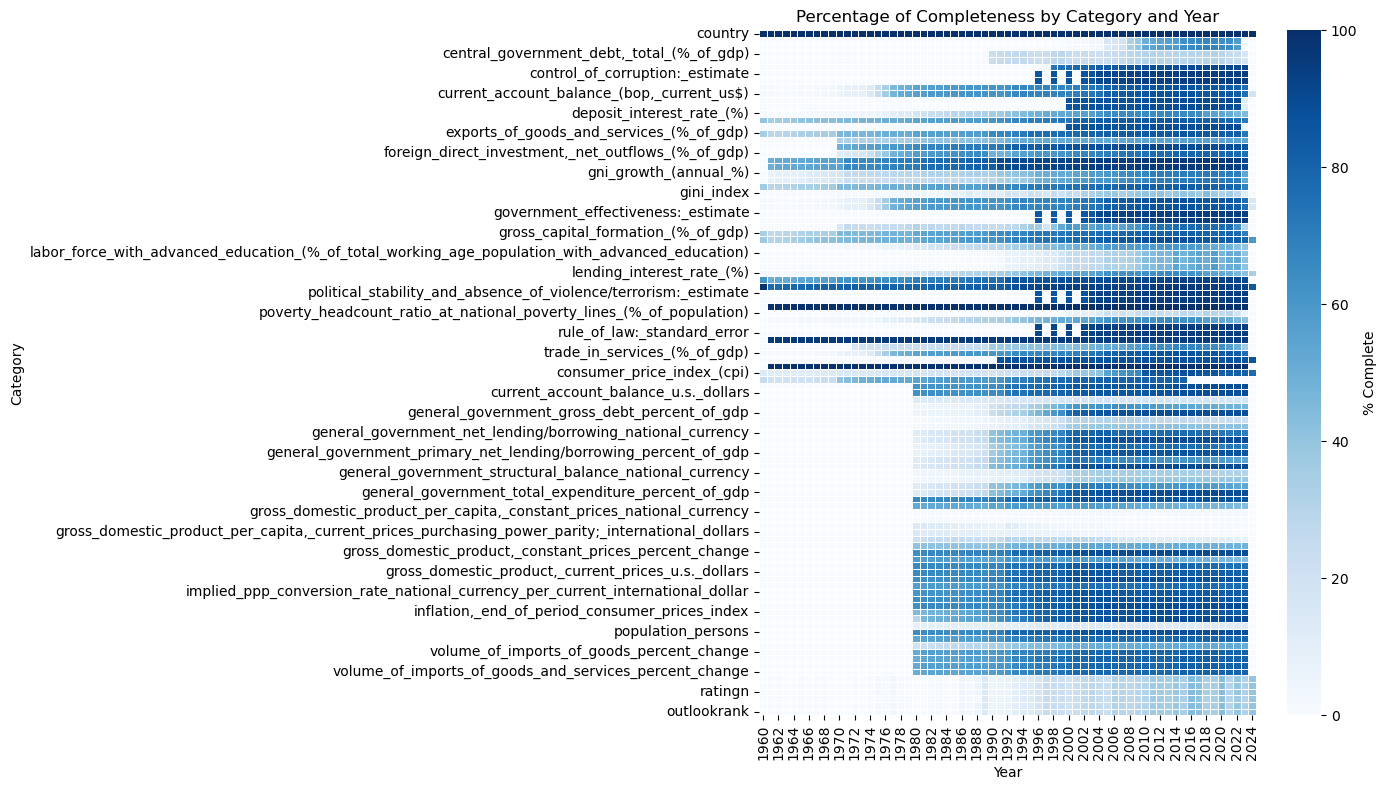

In [226]:
# Check % data completeness per category for all years to decide the period to be removed from data set  
rows_per_year = df_final.groupby('year').size()
non_missing_by_year = df_final.groupby('year').count()
percent_complete = (non_missing_by_year.T / rows_per_year).T * 100
percent_complete = percent_complete.apply(pd.to_numeric, errors='coerce')

plt.figure(figsize=(14, 8))
sns.heatmap(percent_complete.T, cmap="Blues", annot=False, fmt=".1f", linewidths=0.5, cbar_kws={'label': '% Complete'})
plt.title('Percentage of Completeness by Category and Year')
plt.xlabel('Year')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [228]:
# Before year 1980 and for the year 2024 (recent data is not available yet) data is very scarce and we should remove it.
# Filter data only for years between 1980-2023
df_filtered = df_final[df_final['year'].between(1980, 2023)]
df_final = df_filtered.copy()

In [230]:
# Check new distribution
# rows_per_year = df_final.groupby('year').size()
# non_missing_by_year = df_final.groupby('year').count()
# percent_complete = (non_missing_by_year.T / rows_per_year).T * 100
# percent_complete = percent_complete.apply(pd.to_numeric, errors='coerce')

# plt.figure(figsize=(14, 8))
# sns.heatmap(percent_complete.T, cmap="Blues", annot=False, fmt=".1f", linewidths=0.5, cbar_kws={'label': '% Complete'})
# plt.title('Percentage of Completeness by Category and Year')
# plt.xlabel('Year')
# plt.ylabel('Category')
# plt.tight_layout()
# plt.show()

##### 3.3 Cleaning countries that have the most missing values

In [233]:
# Check candidate countries for removal
# 1. Remove countries that have the most missing values e.g. more than 50% of data is missing
# 2. Remove countries for which we don't have any values for the considered output categories 1.ratingn, 2. gross domestic product, constant prices, 
# 3. inflation, average consumer prices, 4. gdp growth (annual %), 5. gdp per capita growth (annual %), 

#============= 1-REMOVE COUNTRIES WITH MOST MISSING VALUES =================

#============ 1.1-Check top 50 countires by missing values =================
# Check percent completeness per country
rows_per_country = df_final.groupby('country').size()
non_missing_by_country = df_final.groupby('country').count()
percent_complete = (non_missing_by_country.T / rows_per_country).T * 100

# Convert values to numeric
percent_complete = percent_complete.apply(pd.to_numeric, errors='coerce')

# # Compute average completeness per country
percent_complete['mean_completeness'] = percent_complete.mean(axis=1)

# Sort by lowest completeness and extract top 50
top_50_incomplete = percent_complete.sort_values(by='mean_completeness').head(50)

# Get the country names
top_50_countries = top_50_incomplete.index.tolist()

# Display result
print('TOP COUNTRIES WITH MISSING VALUES IN [%]')
print("="*40)
print(top_50_incomplete['mean_completeness'].round(2))
print("="*40)

TOP COUNTRIES WITH MISSING VALUES IN [%]
country
St. Martin (French part)      3.31
Gibraltar                     4.46
British Virgin Islands        4.88
Channel Islands               6.20
Northern Mariana Islands      6.66
Sint Maarten (Dutch part)     7.22
Turks and Caicos Islands      7.46
Isle of Man                   8.72
Curacao                      10.04
Guam                         10.90
Virgin Islands (U.S.)        10.92
Liechtenstein                11.01
Monaco                       11.47
Greenland                    11.72
Korea, Dem. People's Rep.    11.76
Cayman Islands               12.60
New Caledonia                12.73
French Polynesia             13.20
Cuba                         20.01
South Sudan                  20.59
Nauru                        23.32
Somalia                      25.15
Sao Tome and Principe        26.19
Andorra                      27.63
Tuvalu                       27.91
Ivory Coast                  28.64
San Marino                   31.16
Kosovo

In [235]:
#===== 1.2-Remove countries with more than 50% missing data =======

# Set the threshold for exclusion
threshold =  50 # value in percent

# Filter for countries with mean completeness below or equal to threshold
incomplete_countries = percent_complete[percent_complete['mean_completeness'] <= threshold].index.tolist()

# Filter df_final to keep only those countries
df_filtered = df_final[~df_final['country'].isin(incomplete_countries)]

df_final = df_filtered.copy()
print('LIST OF REMOVED COUNTRIES')

print("="*150)
print(incomplete_countries)
print("="*150)
print("="*50)
print(f' Total number of countries left: {len(df_final["country"].unique())}')
print("="*50)

LIST OF REMOVED COUNTRIES
['Afghanistan', 'Andorra', 'Aruba', 'British Virgin Islands', 'Cambodia', 'Cayman Islands', 'Channel Islands', 'Cuba', 'Curacao', 'Djibouti', 'Eritrea', 'French Polynesia', 'Gibraltar', 'Greenland', 'Guam', 'Iraq', 'Isle of Man', 'Ivory Coast', 'Kazakhstan', 'Kiribati', "Korea, Dem. People's Rep.", 'Kosovo', 'Laos', 'Liberia', 'Liechtenstein', 'Macau', 'Marshall Islands', 'Micronesia, Fed. Sts.', 'Monaco', 'Montenegro', 'Myanmar', 'Nauru', 'New Caledonia', 'Northern Mariana Islands', 'Palau', 'Puerto Rico', 'San Marino', 'Sao Tome and Principe', 'Serbia', 'Sint Maarten (Dutch part)', 'Somalia', 'South Sudan', 'St. Martin (French part)', 'Syrian Arab Republic', 'Tajikistan', 'Timor-Leste', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu', 'Uzbekistan', 'Virgin Islands (U.S.)', 'Yemen, Rep.', 'Zimbabwe']
 Total number of countries left: 161


In [237]:
#df_final.sample(10)
#df_final['country'].unique().tolist()
#print(len(df_final['country'].unique()))

In [239]:
#============= 2-REMOVE COUNTRIES WITH NO RATINGSN =================

# Check countries where all values are missing for ratingn
no_ratingn_countries = (
    df_final.groupby('country')['ratingn']
    .apply(lambda x: x.isna().all())
    .loc[lambda x: x]  # filter only True
    .index.tolist()
)

#print("Countries with no ratingn at all:")
#print(no_ratingn_countries)

# Drop those countries from the DataFrame
df_final = df_final[~df_final['country'].isin(no_ratingn_countries)]

# Reset index
df_final = df_final.reset_index(drop=True)

print("="*50)
print(f"Removed {len(no_ratingn_countries)} countries with no ratingn at all.")
print("="*50)
print("="*50)
print(f' Total number of countries left: {len(df_final["country"].unique())}')
print("="*50)

Removed 32 countries with no ratingn at all.
 Total number of countries left: 129


In [241]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5676 entries, 0 to 5675
Columns: 104 entries, country to outlookrank
dtypes: Int64(8), datetime64[ns](1), float64(90), int32(1), object(4)
memory usage: 4.5+ MB


##### 3.4 Imputation for missing data

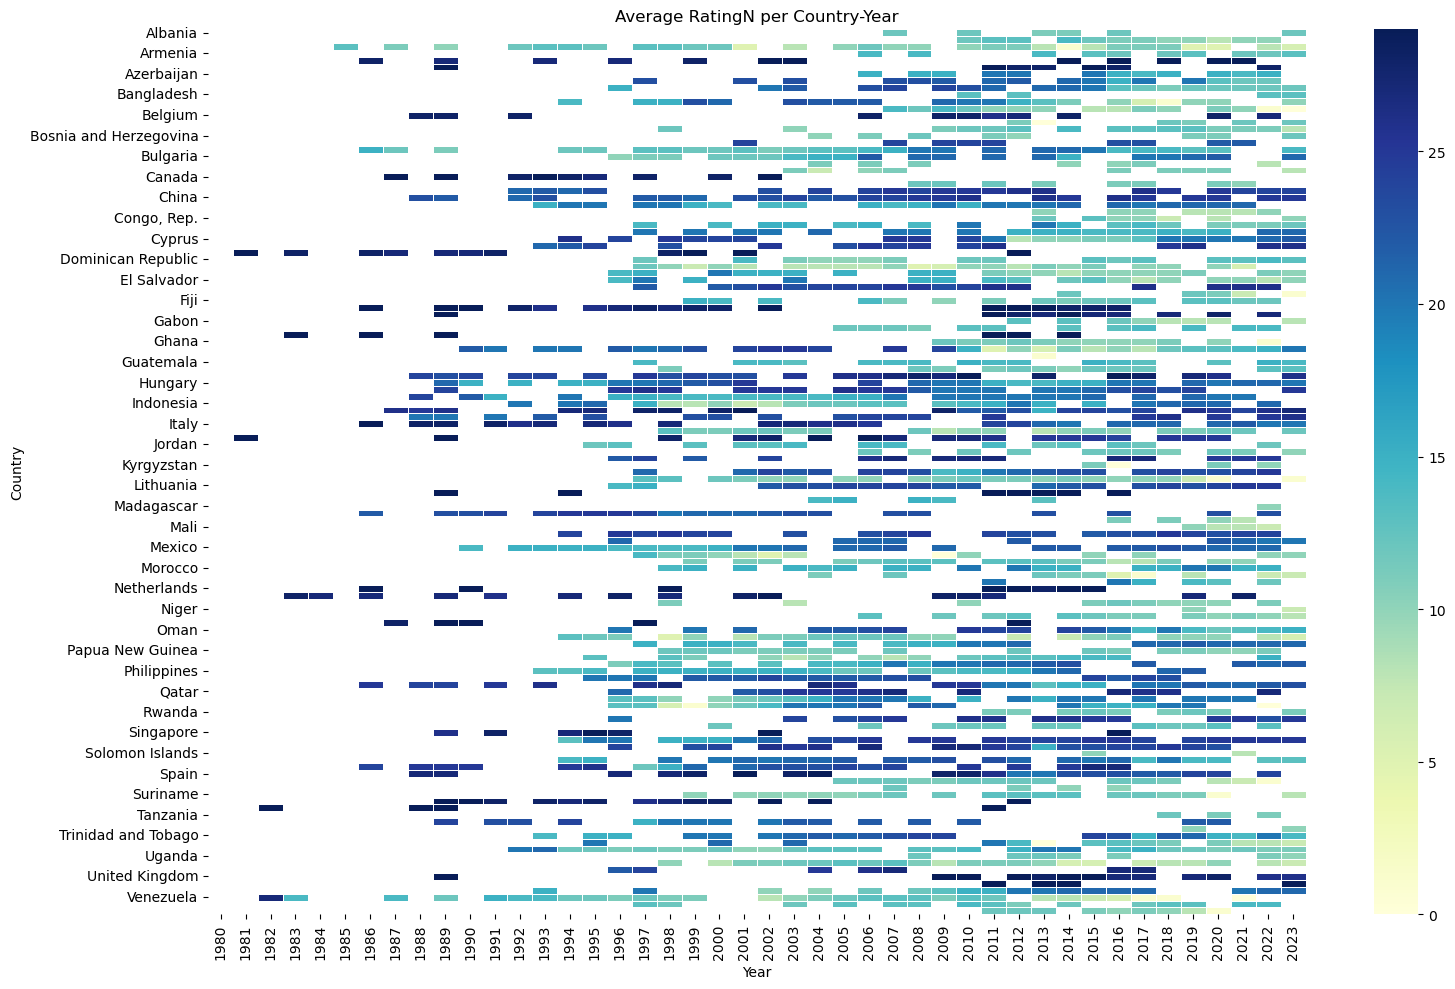

In [243]:
# Check distribution of rating by country and by year to assess the imputation technique for ratingn and outlookrank
# Compute the mean
dfx = df_final.groupby(['country', 'year'])['ratingn'].mean().unstack()
dfx = dfx.astype(float)

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(dfx, cmap='YlGnBu', annot=False, fmt='.1f', linewidths=0.5)
plt.title('Average RatingN per Country-Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [245]:
# Imputation for ratingn should be in two stages: 
#1. Forward fill - fill in forward most on the missing values
#2. Backward fill - fill-in the missing values before the first available record

# Two-stage imputation by country
df_final[['ratingn', 'outlookrank']] = (
    df_final
    .sort_values(['country', 'year'])  # ensure chronological order
    .groupby('country')[['ratingn', 'outlookrank']]
    .transform(lambda x: x.ffill().bfill())
)

# Count remaining missing values
print('Total number of countries without rating or outlook:')
print("="*50)
print(df_final[['ratingn', 'outlookrank']].isna().sum());
print("="*50)

Total number of countries without rating or outlook:
ratingn        0
outlookrank    0
dtype: int64


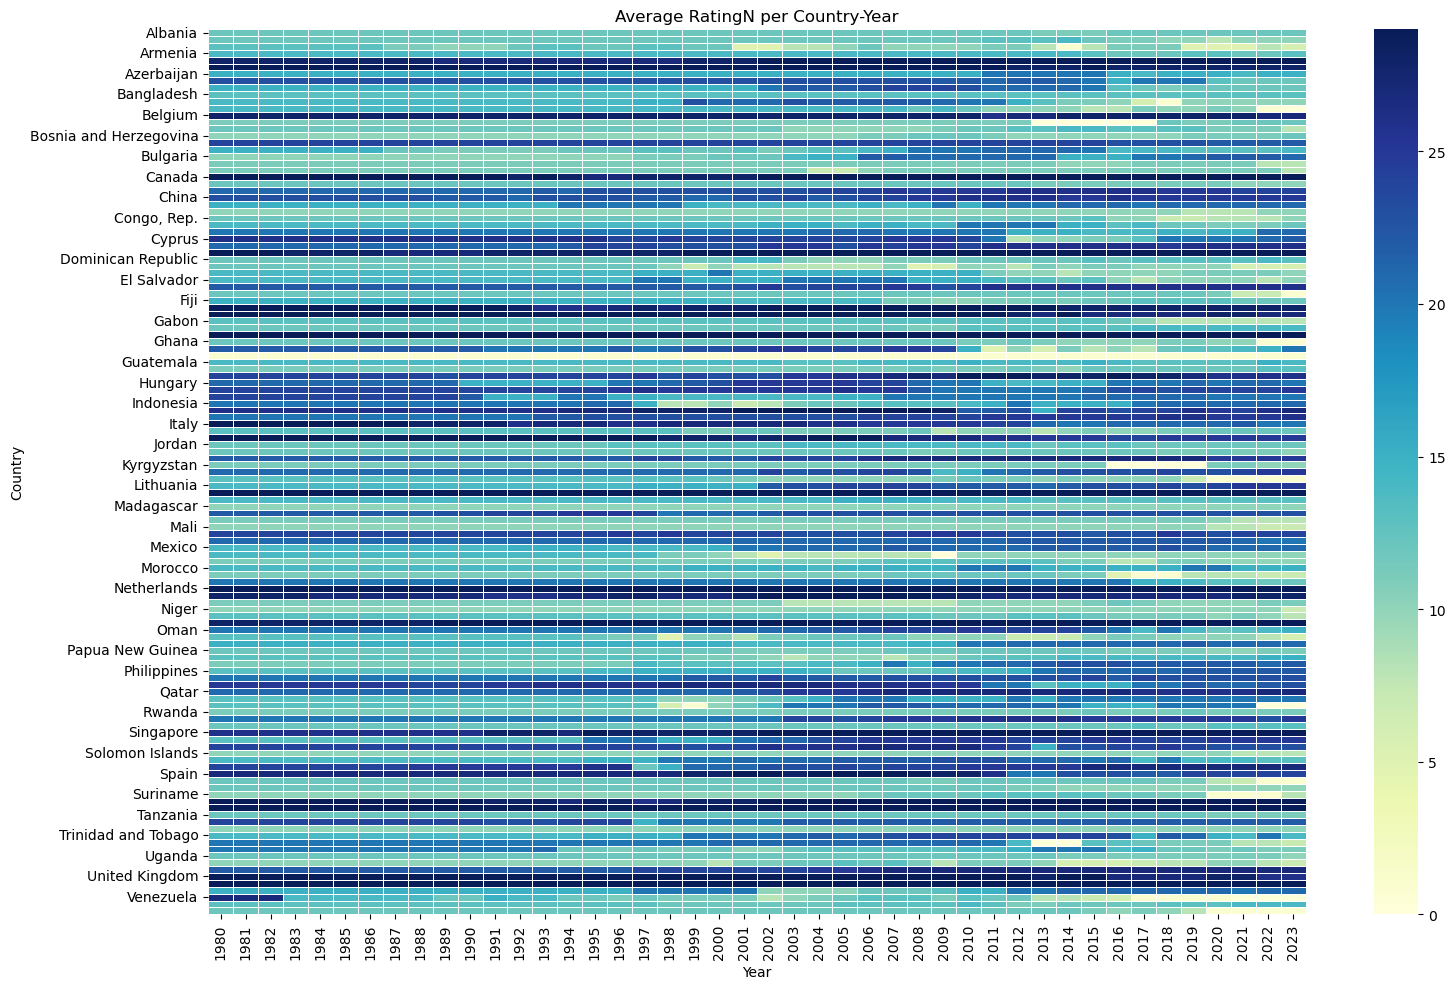

In [247]:
# Check distribution of rating by country and by year to assess the imputation technique
# Compute the mean
#dfx = df_final.groupby(['country', 'year'])['ratingn'].mean().unstack()
dfx = df_final.pivot(index='country', columns='year', values='ratingn')
dfx = dfx.astype(int)

# Plot
plt.figure(figsize=(16, 10))
sns.heatmap(dfx, cmap='YlGnBu', annot=False, linewidths=0.5)
plt.title('Average RatingN per Country-Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [249]:
#df_final.columns.tolist()
#df_final.select_dtypes(include='object').info()
#df_final.select_dtypes(include='int32').info()

In [261]:
# Define imputation strategy for each columns that requires imputation
poly_interpolate_cols = ['bank_capital_to_assets_ratio_(%)', 'bank_nonperforming_loans_to_total_gross_loans_(%)', 'central_government_debt,_total_(%_of_gdp)', 
                         'central_government_debt,_total_(current_lcu)', 'control_of_corruption:_estimate', 'control_of_corruption:_standard_error', 
                         'current_account_balance_(%_of_gdp)', 
                         'current_account_balance_(bop,_current_us$)', 'current_health_expenditure_(%_of_gdp)', 'current_health_expenditure_per_capita,_ppp_(current_international_$)', 
                         'deposit_interest_rate_(%)', 'domestic_credit_to_private_sector_by_banks_(%_of_gdp)', 'domestic_general_government_health_expenditure_(%_of_gdp)', 
                         'exports_of_goods_and_services_(%_of_gdp)', 'external_debt_stocks_(%_of_gni)', 'foreign_direct_investment,_net_inflows_(%_of_gdp)', 
                         'foreign_direct_investment,_net_outflows_(%_of_gdp)', 'gdp_growth_(annual_%)', 'gdp_per_capita_growth_(annual_%)', 'gni_growth_(annual_%)', 
                         'gni_per_capita_growth_(annual_%)', 'general_government_final_consumption_expenditure_(%_of_gdp)', 'gini_index', 'goods_exports_(bop,_current_us$)', 
                         'goods_imports_(bop,_current_us$)', 'government_effectiveness:_estimate', 'government_effectiveness:_standard_error', 
                         'government_expenditure_on_education,_total_(%_of_gdp)', 'gross_capital_formation_(%_of_gdp)', 'inflation,_consumer_prices_(annual_%)', 
                         'interest_rate_spread_(lending_rate_minus_deposit_rate,_%)', 'labor_force_with_advanced_education_(%_of_total_working_age_population_with_advanced_education)', 
                         'labor_force_with_basic_education_(%_of_total_working_age_population_with_basic_education)', 
                         'labor_force_with_intermediate_education_(%_of_total_working_age_population_with_intermediate_education)', 'lending_interest_rate_(%)', 
                         'merchandise_trade_(%_of_gdp)', 'official_exchange_rate_(lcu_per_us$,_period_average)', 'political_stability_and_absence_of_violence/terrorism:_estimate', 
                         'political_stability_and_absence_of_violence/terrorism:_standard_error', 'population_growth_(annual_%)', 
                         'poverty_headcount_ratio_at_national_poverty_lines_(%_of_population)', 'real_interest_rate_(%)', 'rule_of_law:_estimate', 'rule_of_law:_standard_error', 
                         'rural_population_growth_(annual_%)', 'tax_revenue_(%_of_gdp)', 'trade_in_services_(%_of_gdp)', 
                         'unemployment,_total_(%_of_total_labor_force)_(modeled_ilo_estimate)', 'urban_population_growth_(annual_%)', 'consumer_price_index_(cpi)', 
                         'gross_debt,_general_government,_percent_of_fiscal_year_gdp', 'current_account_balance_percent_of_gdp', 'current_account_balance_u.s._dollars', 
                         'employment_persons', 'general_government_gross_debt_national_currency', 'general_government_gross_debt_percent_of_gdp', 
                         'general_government_net_debt_national_currency', 'general_government_net_debt_percent_of_gdp', 'general_government_net_lending/borrowing_national_currency', 
                         'general_government_net_lending/borrowing_percent_of_gdp', 'general_government_primary_net_lending/borrowing_national_currency', 
                         'general_government_primary_net_lending/borrowing_percent_of_gdp', 'general_government_revenue_national_currency', 'general_government_revenue_percent_of_gdp', 
                         'general_government_structural_balance_national_currency', 'general_government_structural_balance_percent_of_potential_gdp', 
                         'general_government_total_expenditure_national_currency', 'general_government_total_expenditure_percent_of_gdp', 
                         'gross_domestic_product_based_on_purchasing_power_parity_(ppp)_share_of_world_total_percent', 
                         'gross_domestic_product_corresponding_to_fiscal_year,_current_prices_national_currency', 'gross_domestic_product_per_capita,_constant_prices_national_currency', 
                         'gross_domestic_product_per_capita,_constant_prices_purchasing_power_parity;_2021_international_dollar', 
                         'gross_domestic_product_per_capita,_current_prices_national_currency', 
                         'gross_domestic_product_per_capita,_current_prices_purchasing_power_parity;_international_dollars', 
                         'gross_domestic_product_per_capita,_current_prices_u.s._dollars', 'gross_domestic_product,_constant_prices_national_currency', 
                         'gross_domestic_product,_constant_prices_percent_change', 'gross_domestic_product,_current_prices_national_currency', 
                         'gross_domestic_product,_current_prices_purchasing_power_parity;_international_dollars', 
                         'gross_domestic_product,_current_prices_u.s._dollars', 'gross_domestic_product,_deflator_index', 
                         'gross_national_savings_percent_of_gdp', 'implied_ppp_conversion_rate_national_currency_per_current_international_dollar', 
                         'inflation,_average_consumer_prices_index', 'inflation,_average_consumer_prices_percent_change', 
                         'inflation,_end_of_period_consumer_prices_index', 'inflation,_end_of_period_consumer_prices_percent_change', 
                         'output_gap_in_percent_of_potential_gdp_percent_of_potential_gdp', 'population_persons', 'total_investment_percent_of_gdp', 
                         'unemployment_rate_percent_of_total_labor_force', 'volume_of_imports_of_goods_percent_change', 
                         'volume_of_exports_of_goods_and_services_percent_change', 'volume_of_exports_of_goods_percent_change', 
                         'volume_of_imports_of_goods_and_services_percent_change']
    
ffill_bfill_cols = ['ratingn', 'outlookrank', 'compulsory_education,_duration_(years)']
mean_fill_cols = []
rolling_avg_cols = []
arima_cols = []

# === Initialize imputation count log ===
imputation_log = {
    'poly_or_linear': 0,
    'ffill_bfill': 0,
    'mean': 0,
    'arima': 0,
    'global_fallback': 0
}

# === Polynomial + fallback to linear ===
def smart_interpolate(series, order=2, min_points=None):
    if min_points is None:
        min_points = order + 1
    if series.notna().sum() >= min_points:
        try:
            return series.interpolate(method='polynomial', order=order, limit_direction='both')
        except Exception:
            return series.interpolate(method='linear', limit_direction='both')
    else:
        return series.interpolate(method='linear', limit_direction='both')

def polynomial_or_linear_imputer(df):
    df = df.copy().sort_values(['country', 'year'])
    for col in poly_interpolate_cols:
        before = df[col].isna().sum()
        df[col] = df.groupby('country')[col].transform(smart_interpolate)
        after = df[col].isna().sum()
        imputation_log['poly_or_linear'] += (before - after)
    return df

# === Forward/Backward Fill ===
def ffill_bfill_imputer(df):
    df = df.copy()
    for col in ffill_bfill_cols:
        before = df[col].isna().sum()
        df[col] = df.groupby('country')[col].transform(lambda x: x.ffill().bfill())
        after = df[col].isna().sum()
        imputation_log['ffill_bfill'] += (before - after)
    return df

# === Mean Imputer ===
def mean_imputer(df):
    df = df.copy()
    for col in mean_fill_cols:
        before = df[col].isna().sum()
        df[col] = df[col].fillna(df[col].mean())
        after = df[col].isna().sum()
        imputation_log['mean'] += (before - after)
    return df

# === ARIMA Imputer ===
def impute_with_arima(series):
    s = series.copy()
    if s.isna().all():
        return s
    try:
        y = s.dropna()
        if len(y) < 3:
            return s
        model = ARIMA(y, order=(0, 1, 1))
        model_fit = model.fit()
        forecast = model_fit.predict(start=s.index[0], end=s.index[-1])
        s[s.isna()] = forecast[s.isna()]
        return s
    except:
        return s

def arima_imputer(df):
    df = df.copy().sort_values(['country', 'year'])
    for col in arima_cols:
        before = df[col].isna().sum()
        df[col] = df.groupby('country')[col].transform(impute_with_arima)
        after = df[col].isna().sum()
        imputation_log['arima'] += (before - after)
    return df

# === Global Fallback Imputer ===
def global_fallback_imputer(df):
    global imputation_log
    df = df.copy()
    
    initial_nan_count = df.isnull().sum().sum()
    
    for col in df.columns:
        if df[col].isnull().any():
            try:
                # Attempt to convert to numeric. Errors will be handled by the except block.
                # 'coerce' will turn non-convertible values into NaN.
                numeric_series = pd.to_numeric(df[col], errors='coerce')
                
                # Check if the column is primarily numeric after coercion.
                # If there are too many NaNs, it might be a categorical column
                if numeric_series.isnull().mean() < 0.5: # Example threshold
                    median_val = numeric_series.median()
                    df[col].fillna(median_val, inplace=True)
                else:
                    # If it's not a numeric column, fill with mode
                    mode_val = df[col].mode()[0]
                    df[col].fillna(mode_val, inplace=True)
            
            except (ValueError, TypeError):
                # If to_numeric fails entirely, it's likely a non-numeric column.
                # Use the mode for imputation.
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
    
    final_nan_count = df.isnull().sum().sum()
    imputed_count = initial_nan_count - final_nan_count
    imputation_log['global_fallback'] += imputed_count
    
    return df

# === Build pipeline ===
impute_pipeline = Pipeline([
    ('poly_or_linear_interp', FunctionTransformer(polynomial_or_linear_imputer, validate=False)),
    ('ffill_bfill', FunctionTransformer(ffill_bfill_imputer, validate=False)),
    ('mean_fill', FunctionTransformer(mean_imputer, validate=False)),
    ('arima_fill', FunctionTransformer(arima_imputer, validate=False)),
    ('global_fallback_fill', FunctionTransformer(global_fallback_imputer, validate=False))
])

# === Apply pipeline ===
df_original = df_final.copy()
df_final = impute_pipeline.fit_transform(df_final)

# === Print imputation summary ===
print("=== Imputation Summary ===")
for method, count in imputation_log.items():
    print(f"{method}: {count} values imputed")

=== Imputation Summary ===
poly_or_linear: 21608 values imputed
ffill_bfill: 2313 values imputed
mean: 0 values imputed
arima: 0 values imputed
global_fallback: 182167 values imputed


In [263]:
still_missing = df_final[ffill_bfill_cols].isna().sum()
print("Still missing after ffill+bfill:\n", still_missing)

# still_missing = df_final[poly_interpolate_cols].isna().sum()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', None):
#     print("Still missing after Polynomial + fallback to linear:\n")
#     print(still_missing)

Still missing after ffill+bfill:
 ratingn                                   0
outlookrank                               0
compulsory_education,_duration_(years)    0
dtype: int64


In [267]:
# Step 1: Base missing summary per country
missing_summary = (
    df_final.groupby('country')['population_persons']
    .agg(total_values='count', total_rows='size')  # count = non-missing, size = all
    .reset_index()
)

# Step 2: Add missing count and percentage
missing_summary['missing_count'] = missing_summary['total_rows'] - missing_summary['total_values']
missing_summary['missing_percent'] = (missing_summary['missing_count'] / missing_summary['total_rows']) * 100
missing_summary['missing_percent'] = missing_summary['missing_percent'].round(2)

# Step 3: Compute first and last year for each country from df_final
year_bounds = (
    df_final.groupby('country')['year']
    .agg(first_year='min', last_year='max')
    .reset_index()
)

# Step 4: Merge year bounds into missing_summary
missing_summary = missing_summary.merge(year_bounds, on='country', how='left')

# Step 5: Filter only countries with missing data
missing_summary = missing_summary[missing_summary['missing_count'] > 0]

# Step 6: Display result
print(missing_summary[['country', 'missing_count', 'total_rows', 'missing_percent', 'first_year', 'last_year']])


Empty DataFrame
Columns: [country, missing_count, total_rows, missing_percent, first_year, last_year]
Index: []


In [269]:
df_final[df_final['country'] == 'Romania'].groupby('year')['population_persons'].first()

year
1980    22.442
1981    22.576
1982    22.683
1983    22.775
1984    22.868
1985    22.971
1986    23.093
1987    23.224
1988    23.346
1989    23.431
1990    23.459
1991    23.423
1992    23.333
1993    23.205
1994    23.064
1995    22.927
1996    22.800
1997    22.679
1998    22.565
1999    22.458
2000    22.455
2001    22.430
2002    21.833
2003    21.628
2004    21.521
2005    21.382
2006    21.257
2007    21.131
2008    20.635
2009    20.440
2010    20.295
2011    20.199
2012    20.096
2013    20.020
2014    19.947
2015    19.871
2016    19.761
2017    19.644
2018    19.533
2019    19.414
2020    19.329
2021    19.202
2022    19.042
2023    19.055
Name: population_persons, dtype: float64

In [ ]:
# Check distribution of data across the countries
rows_per_country = df_final.groupby('country').size()
non_missing_by_country = df_final.groupby('country').count()
percent_complete = (non_missing_by_country.T / rows_per_country).T * 100
percent_complete = percent_complete.apply(pd.to_numeric, errors='coerce')

# Sort by average completeness
percent_complete['mean_completeness'] = percent_complete.mean(axis=1)
percent_complete = percent_complete.sort_values(by='mean_completeness', ascending=True)
percent_complete = percent_complete.drop(columns='mean_completeness')

plt.figure(figsize=(14, 8))
sns.heatmap(
    percent_complete.T,
    cmap="Blues",
    annot=False,
    fmt=".1f",
    linewidths=0.5,
    cbar_kws={'label': '% Complete'}
)
plt.title('Percentage of Completeness by Category and Country (Sorted)')
plt.xlabel('Country')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

##### 3.5 Removing categories that are are not needed or have too many missing values

In [ ]:
#Check top categories with most of the missing data
df_cat_to_remove = df_final.isna().mean().multiply(100).sort_values(ascending=False).round(2).head(10)
print('         ======== TOP 10 CATEGORIES WITH MISSING DATA ========')
print("="*75)
print(df_cat_to_remove)
print("="*75)

In [ ]:
# Removing top 10 categories
df_cat_to_remove = df_cat_to_remove.index.tolist()
df_filtered = df_final.drop(columns=df_cat_to_remove)
df_final = df_filtered.copy()

In [ ]:
print(df_final.isna().mean().multiply(100).sort_values(ascending=False).round(2).head(10))

In [ ]:
# df_final['missing_count'] = df_final.isna().sum(axis=1)

# # 2. Group by country and sum missing values
# missing_by = (
#     df_final.groupby(['country','year'])['missing_count']
#     .sum()
#     .sort_values(ascending=False)
# )
# print(missing_by['Romania'])

In [ ]:
df_final['missing_count'] = df_final.isna().mean(axis=1)
missing_by_country_year = df_final.groupby(['year', 'country'])['missing_count'].sum().reset_index()

heatmap_data = missing_by_country_year.pivot(index='country', columns='year', values='missing_count')

plt.figure(figsize=(16, 8))
sns.heatmap(heatmap_data, cmap='Reds', annot=False, fmt='.0f', linewidths=0.5)
plt.title('Missing Values by Country and Year')
plt.xlabel('Year')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [ ]:
#Check missing values for each category and their distribution

missing_val = df_final.isna().mean().multiply(100).round(2)
missing_val_over60 = missing_val[missing_val >= 30]

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(data=missing_val_over60, ax=axes[0])
axes[0].set_title('Distribution of missing values by category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('% missing values')
axes[0].tick_params(axis='x', rotation=90)

sns.heatmap(data=df_final.isna(), ax=axes[1])
axes[1].set_title('Missing values by Categories')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Number');

In [ ]:
# Check missing data distribution by years to identity the period that should be discarded due to missing data

# Histogram/Barplots for numerical variables
df_final.drop(columns=['year']).hist(bins=50, figsize=(50, 50))
plt.show()

In [ ]:
country = 'Albania'
df_filtered_by_country = df_final[df_final['country'] == country]
#print(f"\nDataFrame filtered for category: '{country}'")
#print(df_filtered_by_country)

df_filtered_by_country.hist(bins=20, figsize=(50, 50))
plt.suptitle(f'Histograms for {country} Category', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [ ]:
#df_final['year'].describe()

In [ ]:
print(df_final.isna().mean().multiply(100).sort_values(ascending=False).round(2).head(10))

In [ ]:
# # Check duplicated rows
# #print(all_duplicated_rows = df_ratings[df_ratings.duplicated(keep=False)]
# # Highlight max values in 'Salary' and 'Performance'
# # # Apply a gradient background to 'Age'
# styled_df = df_ratings.style \
#      .highlight_max(subset=['Agency', 'RatingN'], color='lightgreen') \
#      .background_gradient(subset=['Year'], cmap='Blues') \
#      .format({'RatingN': '${:,.2f}'}) \
#      .set_caption("Employee Data Overview") \
#      .set_properties(**{'font-size': '10pt', 'border': '1px solid black'})
# styled_df

In [ ]:
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total Elapsed time : {elapsed_time/60} Minutes")